Get PV correlation means and stds for a power calculation.

In [3]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    # sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sd_paper/analysis_and_figure_code/DataPaths'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
    group_data_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/Clustering/grpdata")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
        group_data_dir = Path('/data/Clustering/grpdata')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])


    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set parameters for place fields

In [39]:
frate_thresh = 3  # must have at least one bin above this value to be considered a place field

## Load in previously calculated place field tuning curves

In [4]:
tc_all = pd.read_csv(group_data_dir / "tc_all.csv", index_col=0)
tc_all

0         1         2         3         4         5          6  \
0     0.000000  0.000000  0.664043  0.298140  1.202241  0.639808   0.120662   
1     0.207612  0.012711  0.027668  0.204733  0.090885  0.034121   0.130268   
2     1.038062  1.272878  1.153802  1.481709  1.286844  0.946563   0.633890   
3     2.906574  2.131475  1.057192  0.486249  0.376315  0.178261   0.123277   
4    13.702422  7.676248  5.706135  4.906915  5.382127  8.943502  12.748299   
..         ...       ...       ...       ...       ...       ...        ...   
917   0.000000  0.202666  0.264557  0.146939  0.000000  0.000000   0.147529   
918   2.101167  0.153854  0.195986  0.319734  0.778995  0.995184   1.200739   
919   0.000000  0.146437  0.000000  0.000000  0.107591  0.092978   0.000000   
920   1.400778  3.562097  4.106440  3.507618  3.904169  5.688379   2.861642   
921   0.000000  0.048812  0.058843  0.000000  0.000000  0.000000   0.000000   

             7          8          9  ...        92         93        94  \
0     0.020136   0.000000   0.000000  ...  0.000000   0.000000  0.000000   
1     0.080546   0.000000   0.000000  ...  0.000000   0.000000  0.235479   
2     0.419685   0.720616   0.879570  ...  0.580255   0.268528  0.000000   
3     0.225562   0.141560   0.000000  ...  0.300752   0.565374  1.065125   
4    16.544660  17.539733  14.345243  ...  0.559006   0.296846  0.358689   
..         ...        ...        ...  ...       ...        ...       ...   
917   0.088235   0.024507   0.000000  ...  7.706031  15.771429  4.860202   
918   1.676471   1.105364   2.749186  ...  1.294102   9.959184  6.867298   
919   0.000000   0.185730   0.109684  ...  0.000000   0.000000  0.000000   
920   2.470588   1.897298   0.966948  ...  0.000000   0.000000  0.000000   
921   0.000000   0.303102   0.192077  ...  0.000000   0.000000  0.157537   

           95        96        97        98            99  session  grp  
0    0.000000  0.000000  0.000000  0.000000  0.000000e+00        0  NSD  
1    0.388540  0.000000  0.000000  0.000000  0.000000e+00        0  NSD  
2    0.000000  0.000000  0.000000  0.000000  0.000000e+00        0  NSD  
3    1.165620  0.000000  0.000000  0.000000  0.000000e+00        0  NSD  
4    0.000000  0.000000  0.000000  0.000000  0.000000e+00        0  NSD  
..        ...       ...       ...       ...           ...      ...  ...  
917  0.057286  0.000000  0.000000  0.000000  0.000000e+00        7   SD  
918  3.100058  6.270836  4.988732  1.415816  0.000000e+00        7   SD  
919  1.004710  0.250683  0.000000  0.000000  0.000000e+00        7   SD  
920  0.000000  0.716775  5.439288  0.918367 -4.440892e-16        7   SD  
921  0.014322  0.000000  0.000000  0.000000  0.000000e+00        7   SD  

[922 rows x 102 columns]

In [57]:
tc_sesh[frate_bool].shape

(30, 102)

In [50]:
frate_bool.shape[0]

60

In [46]:
frate_bool.sum() / len(frate_bool)

0.5

In [43]:
frate_bool = tc_sesh.iloc[:, :50].max(axis=1) > frate_thresh

30

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

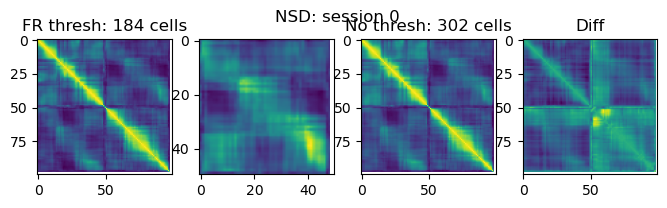

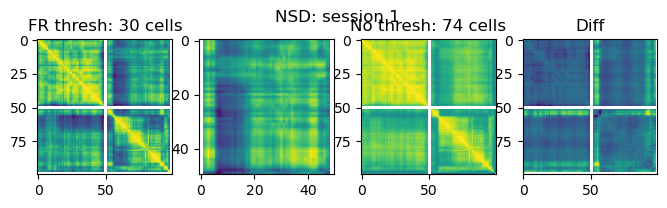

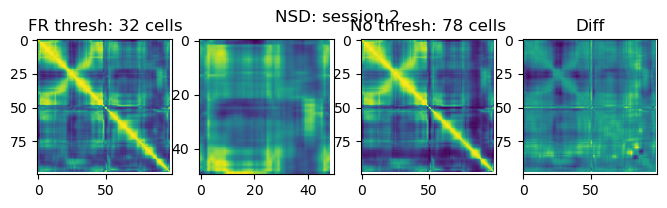

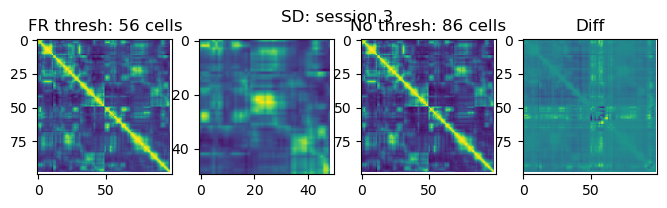

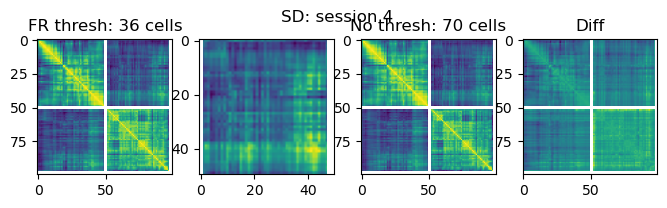

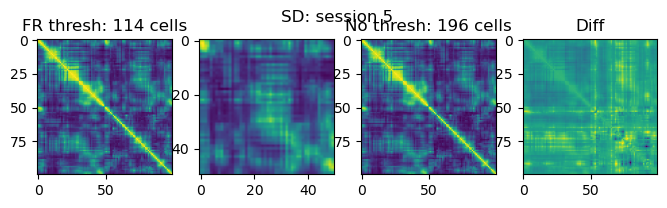

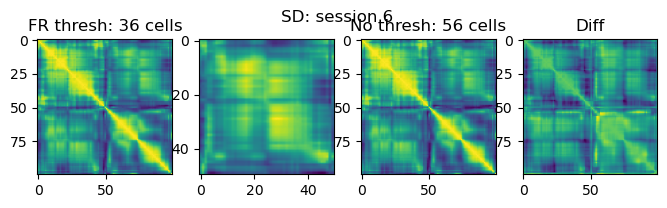

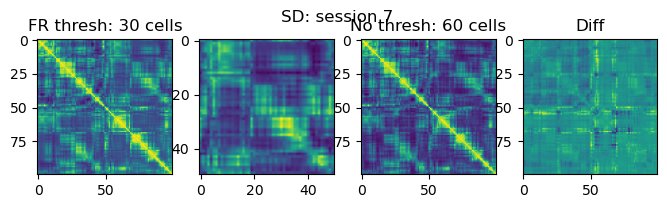

In [61]:
nbins_per_sesh = 50

corrs_diag_df = []
for grp in ["NSD", "SD"]:
    tc_grp = tc_all[tc_all.grp == grp]
    
    for sid in tc_grp.session.unique():
        fig, ax = plt.subplots(1, 4, figsize=(8, 2))

        # Load in tuning curves all with the same # bins (and therefore different sizes..., approximate)
        # bins 0:nbins_per_sesh = MAZE, nbins_per_sesh: = reMAZE
        tc_sesh = tc_grp[tc_grp.session == sid]

        # FR threshold - only include cells with FR above thresh in MAZE
        frate_bool = tc_sesh.iloc[:, :nbins_per_sesh].max(axis=1) > frate_thresh
        tc_sesh_thresh = tc_sesh[frate_bool]

        # Get PV correlation matrix
        corr_array = np.corrcoef(tc_sesh_thresh.drop(columns=["session", "grp"]).to_numpy().T)
        corr_array_no_thresh = np.corrcoef(tc_sesh.drop(columns=["session", "grp"]).to_numpy().T)

        # Plot it for a sanity check
        ax[0].imshow(corr_array)
        corr_maze_rmaze = corr_array[0:nbins_per_sesh, nbins_per_sesh:]
        ax[0].set_title(f"FR thresh: {frate_bool.sum()} cells")
        
        ax[1].imshow(corr_maze_rmaze)
        fig.suptitle(f"{grp}: session {sid}")

        ax[2].imshow(corr_array_no_thresh)
        ax[2].set_title(f"No thresh: {frate_bool.shape[0]} cells")

        ax[3].imshow(corr_array - corr_array_no_thresh)
        ax[3].set_title("Diff")

        # save correlations along diagonal (same bin from MAZE to reMAZE) 
        diag_corrs = pd.DataFrame(corr_maze_rmaze[np.eye(50, dtype=bool)][None, :], index=[sid])
        diag_corrs["session"] = sid
        diag_corrs["grp"] = grp
        
        corrs_diag_df.append(diag_corrs)

corrs_diag_df = pd.concat(corrs_diag_df, axis=0)

In [62]:
corrs_diag_df

0         1         2         3         4         5         6  \
0  0.081268  0.294919  0.246253  0.246150  0.191208  0.164654  0.120352   
1       NaN  0.468271  0.563058  0.760690  0.503543  0.468983  0.173611   
2  0.412295  0.195081  0.378981  0.590836  0.590389  0.602377  0.634672   
3  0.198442  0.481060  0.729800  0.398021  0.288125  0.345102  0.033713   
4       NaN  0.082215 -0.006131 -0.128823  0.022302  0.113814  0.123021   
5  0.776585  0.892453  0.795748  0.582324  0.372126  0.314647  0.150201   
6  0.481589  0.543587  0.645612  0.323791  0.399994  0.348483  0.581347   
7  0.230870 -0.046686  0.233478  0.316386  0.502277  0.230707  0.316249   

          7         8         9  ...        42        43        44        45  \
0  0.112337  0.156578  0.219058  ...  0.411848  0.389735  0.418294  0.366140   
1  0.301395  0.333705  0.318962  ...  0.809022  0.812482  0.638845  0.565172   
2  0.652582  0.586659  0.528109  ...  0.014544  0.127752  0.336253  0.367770   
3  0.143327 -0.015383 -0.005027  ...  0.386282  0.133076  0.272335  0.399739   
4 -0.019279  0.133618  0.056086  ...  0.580012  0.568575  0.367525  0.251592   
5 -0.002355  0.062521  0.093921  ...  0.460889  0.366690  0.326689  0.432170   
6  0.585692  0.670229  0.684563  ...  0.585868  0.590747  0.583094  0.605872   
7  0.492819  0.364017  0.347651  ...  0.313272  0.417176  0.659701  0.610548   

         46        47        48        49  session  grp  
0  0.327029  0.049176 -0.013047       NaN        0  NSD  
1  0.511426  0.348890  0.220360       NaN        1  NSD  
2  0.585009  0.526484  0.371905       NaN        2  NSD  
3  0.623686  0.656721  0.445287       NaN        3   SD  
4  0.166130  0.366302       NaN       NaN        4   SD  
5  0.619344  0.533516  0.621507  0.445512        5   SD  
6  0.217167  0.208918  0.101646 -0.025227        6   SD  
7  0.532045  0.154930  0.350021 -0.113965        7   SD  

[8 rows x 52 columns]

## Now do power calculation

### First calculate PV mean and std

In [92]:
PV_mean = corrs_diag_df.groupby(["grp", "session"]).apply(lambda x: np.nanmean(x, axis=1)[0]).reset_index().rename(columns={0: "PVmean"})
PV_mean

grp  session    PVmean
0  NSD        0  0.265087
1  NSD        1  0.491471
2  NSD        2  0.236726
3   SD        3  0.332801
4   SD        4  0.116238
5   SD        5  0.367790
6   SD        6  0.550084
7   SD        7  0.360835

In [95]:
sesh_mean = PV_mean.drop(columns="session").mean(numeric_only=True).values[0]
sesh_std = PV_mean.drop(columns="session").std(numeric_only=True).values[0]

### Second plot session means
Looks like there is no difference in "drift" between NSD and SD.  

That's ok, use the overall group mean and variance to perform power calculation

<Axes: xlabel='grp', ylabel='PVmean'>

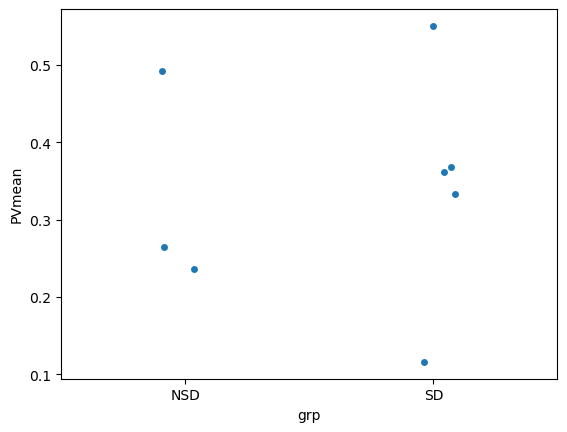

In [98]:
_, ax = plt.subplots()
sns.stripplot(data=PV_mean, x="grp", y="PVmean", dodge=True, ax=ax)

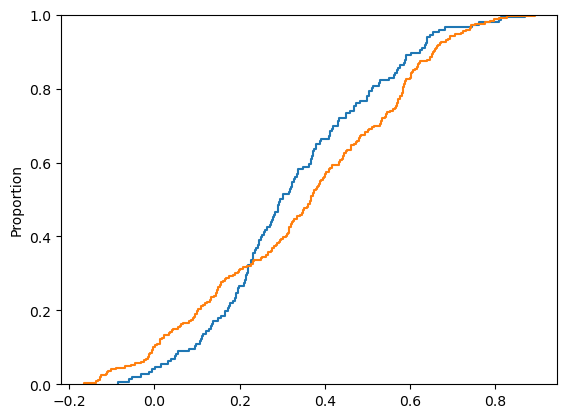

In [99]:
_, ax = plt.subplots()
for grp in ["NSD", "SD"]:
    sns.ecdfplot(data=corrs_diag_df[corrs_diag_df.grp == grp].drop(columns=["grp", "session"]).to_numpy().reshape(1, -1).squeeze(), ax=ax)

### Power calculation!
Assume the mean and standard deviation for PV correlations from above. This is much smaller than observed by Mankin et al. (2012) which is probably due to differences in methodology.

She PV (10 min gap) =  0.85, and PV (6 hr gap) =  0.7, so a 0.15 change from AM to PM (6 hour diff) in CA1. Assume we want to detect between group differences of around that magnitude, so use variance from above to do power calculation.

In [102]:
stats.ttest_ind_from_stats(0, sesh_std, 8, 0.15, sesh_std, 8)m

Ttest_indResult(statistic=-2.162777671989081, pvalue=0.04835149198735069)

So, we get a p-value of 0.048 using a group size of 8, assuming the variance above. This would allow us to detect changes on the order of what we would expect from Mankin et al. (2012) under normal sleep conditions.

In [97]:
stats.ttest_ind(PV_mean[PV_mean.grp == "NSD"].PVmean.values - , PV_mean[PV_mean.grp == "SD"].PVmean.values)

TtestResult(statistic=-1.3221594541371509, pvalue=0.23428137191387577, df=6.0)